In [1]:
import os
import re
import yaml

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from collections import defaultdict

In [2]:
# Monta o Google Drive
from google.colab import drive

print("Montando o Google Drive...")
drive.mount('/content/drive')

Montando o Google Drive...
Mounted at /content/drive


In [10]:
# Define o caminho para salvar o projeto no Drive
DBT_DIR = '/content/drive/MyDrive/dbt_projects'
PROJECT_NAME = "dbt_meu_projeto"
PROJECT_PATH = f"{DBT_DIR}/{PROJECT_NAME}"

In [12]:
# Muda para esse diretório
os.chdir(PROJECT_PATH)

In [3]:


def extrair_modelos_dependencias_e_testes(models_path):
    modelos = []
    dependencias = []

    # Regex para capturar {{ source('schema', 'table') }}
    regex_source = re.compile(r"source\(\s*'([^']+)'\s*,\s*'([^']+)'\s*\)")

    for root, _, files in os.walk(models_path):
        for file in files:
            if file.endswith(".sql"):
                caminho_relativo = os.path.relpath(os.path.join(root, file), models_path)
                nome_modelo = os.path.splitext(caminho_relativo.replace(os.sep, "_"))[0]
                modelos.append(nome_modelo)

                with open(os.path.join(root, file)) as f:
                    conteudo = f.read()

                    # Extrai dependências do tipo {{ ref('...') }}
                    refs = re.findall(r"ref\(\s*'([^']+)'\s*\)", conteudo)
                    for ref in refs:
                        dependencias.append((nome_modelo, f"{ref}"))

                    # Extrai dependências do tipo {{ source('...', '...') }}
                    sources = regex_source.findall(conteudo)
                    for schema, tabela in sources:
                        nome_source = f"{schema}.{tabela}"
                        dependencias.append((nome_modelo, nome_source))

            elif file.endswith(".yml"):
                with open(os.path.join(root, file)) as f:
                    yml_content = yaml.safe_load(f)
                    if not yml_content:
                        continue
                    if "models" in yml_content:
                        for modelo in yml_content["models"]:
                            if "name" in modelo:
                                nome_modelo = modelo["name"]
                                nome_teste = f"test_{nome_modelo}"
                                dependencias.append((nome_teste, nome_modelo))
                                modelos.append(nome_teste)

    # Agrupa dependências por modelo, removendo duplicados
    modelos_unicos = defaultdict(set)
    for destino, origem in dependencias:
        modelos_unicos[destino].add(origem)

    # Junta com modelos que não têm dependências
    for modelo in modelos:
        if modelo not in modelos_unicos:
            modelos_unicos[modelo] = set()

    return [(destino, list(origens)) for destino, origens in modelos_unicos.items()]

In [13]:
# Define os modelos e dependências
modelos_e_testes = extrair_modelos_dependencias_e_testes(models_path="models")

modelos_sem_staging = []
for destino, origens in modelos_e_testes:
    destino_limpo = destino.replace("staging_", "")
    origens_limpos = [origem.replace("staging_", "") for origem in origens]
    modelos_sem_staging.append((destino_limpo, origens_limpos))

modelos_sem_marts = []
for destino, origens in modelos_sem_staging:
    destino_limpo = destino.replace("marts_", "")
    origens_limpos = [origem.replace("marts_", "") for origem in origens]
    modelos_sem_marts.append((destino_limpo, origens_limpos))

modelos_e_testes = modelos_sem_marts

# Imprime cada dependência em uma linha
for dependencia in modelos_e_testes:
    print(dependencia)

('silver_investment', ['bronze_investment'])
('bronze_investment', ['sample_data.marketing_data'])
('gold_investment', ['silver_investment'])
('bronze_kpi', ['sample_data.marketing_data'])
('silver_kpi', ['bronze_kpi'])
('gold_kpi', ['silver_kpi'])
('silver_auxiliar', ['bronze_auxiliar'])
('bronze_auxiliar', ['sample_data.marketing_data'])
('gold_auxiliar', ['silver_auxiliar'])
('test_gold_auxiliar', ['gold_auxiliar'])
('test_gold_kpi', ['gold_kpi'])
('test_gold_investment', ['gold_investment'])


In [14]:
G = nx.DiGraph()
for destino, origens in modelos_e_testes:
    G.add_node(destino)
    for origem in origens:
        G.add_node(origem)
        G.add_edge(origem, destino)

In [15]:
camadas = {
    "source": [],
    "bronze": [],
    "silver": [],
    "gold": [],
    "test": [],
    "outros": []
}

for modelo, origens in modelos_e_testes:
    # Classifica o destino (modelo)
    if modelo.startswith("bronze"):
        camadas["bronze"].append(modelo)
    elif modelo.startswith("silver"):
        camadas["silver"].append(modelo)
    elif modelo.startswith("gold"):
        camadas["gold"].append(modelo)
    elif modelo.startswith("test"):
        camadas["test"].append(modelo)
    else:
        camadas["outros"].append(modelo)

    # Classifica as origens (sources)
    for origem in origens:
        if "." in origem and origem not in camadas["source"]:
            camadas["source"].append(origem)

In [16]:
def gerar_layout_por_grupo_e_gold_test(camadas):
    pos = {}
    espacamento_x = 5
    espacamento_y = 3

    grupos = ['investment', 'kpi', 'auxiliar']
    camada_ordem = ['source', 'bronze', 'silver', 'gold_test', 'outros']

    # Mapeia colunas dos grupos para alinhamento
    grupo_x_map = {grupo: idx * espacamento_x for idx, grupo in enumerate(grupos)}
    centro_x = sum(grupo_x_map.values()) / len(grupo_x_map)

    for idx_camada, camada in enumerate(camada_ordem):
        y = -idx_camada * espacamento_y

        if camada in ['bronze', 'silver']:
            for grupo in grupos:
                nome = f"{camada}_{grupo}"
                if nome in camadas.get(camada, []):
                    x = grupo_x_map[grupo]
                    pos[nome] = (x, y)

        elif camada == 'gold_test':
            for grupo in grupos:
                nome_gold = f"gold_{grupo}"
                nome_test = f"test_gold_{grupo}"
                x_base = grupo_x_map[grupo]
                if nome_gold in camadas.get('gold', []):
                    pos[nome_gold] = (x_base, y)
                if nome_test in camadas.get('test', []):
                    pos[nome_test] = (x_base + 1.5, y)  # test ao lado direito de gold

        elif camada == 'source':
            camada_nos = camadas.get('source', [])
            total_largura = (len(grupos) - 1) * espacamento_x
            deslocamento = centro_x - (len(camada_nos) - 1) * espacamento_x / 2
            for i, no in enumerate(camada_nos):
                x = i * espacamento_x + deslocamento
                pos[no] = (x, y)

        elif camada == 'outros':
            camada_nos = camadas.get('outros', [])
            for j, no in enumerate(camada_nos):
                x = j * espacamento_x
                pos[no] = (x, y)

    return pos

pos = gerar_layout_por_grupo_e_gold_test(camadas)

In [17]:
# Verifica quais nós do grafo não estão no pos
faltando = [n for n in G.nodes if n not in pos]
print("Nós sem posição:", faltando)

Nós sem posição: []


In [18]:
formatos = {
    "source": {"shape": "h", "color": "#e0e0e0"},       # cinza claro neutro
    "bronze": {"shape": "o", "color": "#cd7f32"},       # bronze
    "silver": {"shape": "s", "color": "#c0c0c0"},       # prata
    "test": {"shape": "d", "color": "#e6ccff"},         # lilás claro
    "gold": {"shape": "^", "color": "#ffd700"},         # ouro
    "outros": {"shape": "8", "color": "#f8d7da"},       # vermelho claro
}


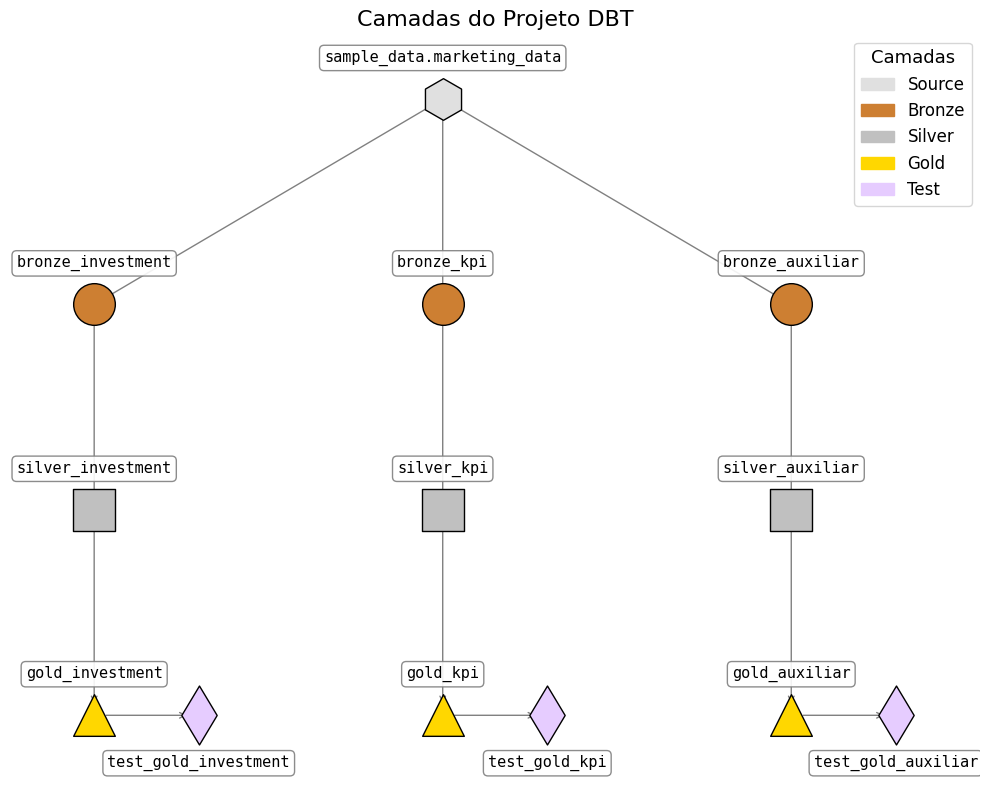

In [19]:
plt.figure(figsize=(10, 8))
legenda = {}

# Desenha os nós
for camada, modelos in camadas.items():
    if not modelos:
        continue
    props = formatos[camada]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=modelos,
        node_shape=props["shape"],
        node_color=props["color"],
        label=camada,
        node_size=900,
        edgecolors='black'
    )
    legenda[camada] = props

# Arestas
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', edge_color="gray")

# Labels
labels = {n: n for n in G.nodes()}
label_pos = {}

for n in G.nodes():
    camada_do_no = next((camada for camada, nos in camadas.items() if n in nos), None)

    if camada_do_no == "test":
        # Coloca abaixo
        label_pos[n] = (pos[n][0], pos[n][1] - 0.7)
    else:
        # Coloca acima
        label_pos[n] = (pos[n][0], pos[n][1] + 0.6)

nx.draw_networkx_labels(
    G, label_pos,
    labels=labels,
    font_size=11,
    font_family="monospace",
    bbox=dict(
        facecolor="white",
        edgecolor="gray",
        boxstyle="round,pad=0.3",
        alpha=0.9
    )
)

# Legenda com primeira letra maiúscula e fonte maior
patches = [
    mpatches.Patch(color=props["color"], label=camada.capitalize())
    for camada, props in legenda.items()
]
plt.legend(handles=patches, title="Camadas", loc="upper right", fontsize=12, title_fontsize=13)

plt.title("Camadas do Projeto DBT", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()